# Factor Backtesting. Here we evaluate the Long Porfoflio of stocks with key metrics as Sharpe Ratio, Return, Volatility, Drawdown with an ability to beat Benchmark(Nifty 50 & Nifty Midcap Index) 

In [25]:
import sys
sys.path.insert(0, "./ffn-master/")
import ffn
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import json

In [26]:
#***********************This Section is to read from saved file and index*****************
concat_df=pd.read_csv('data/Prediction_Output.csv')
concat_df['Date']= pd.to_datetime(concat_df['Date'])
concat_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Industry', 'Symbol',
       'Capitalization', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'Share_Turnover', 'Return', 'Momentum', 'Mom_Sharpe',
       'Mom_Gain_Loss', 'Mom_Slope', 'StDev', 'Liquidity', 'Volatility',
       'NSE500', 'CAPM_Beta', 'CAPM_Alpha', 'Sector_Return', 'Sales', 'OPM',
       'NetProfit', 'EPSinRs', 'DividendPayout', 'OtherLiabilities',
       'Open_Shares', 'Sales_Growth', 'EPS_Growth', 'OPM_Growth', 'ROE',
       'Leverage', 'BVPS', 'Sale_per_share', 'EPS in Rs', 'EPS', 'E/P',
       'Sales/Price', 'BV/Price', 'PEG', 'Div/Price', 'Size_Factor', 'Quality',
       'Value', 'Cum_Return', 'LGBM_Prob_2.0%hit', 'LGBM_Prob_5.0%hit',
       'LGBM_Prob_7.5%hit'],
      dtype='object')

# Function to calculate long only portfolio. We can specific rebalancing dates(Weekly=5, Monthly=22, Yearly=250) and Stocks to screen(like top 200, 100, 20 stocks per rebalance date)

In [27]:
def evaluate_Long_Portfolio(predict_frame, factor_name, rebalance_period= 10,screen_stock=10):
    concat_df2=predict_frame.groupby("Date").apply(lambda x: x.nlargest(screen_stock,factor_name)).droplevel(1)
    concat_df2=concat_df2.groupby(concat_df2.index).filter(lambda x:len(x) == screen_stock)
    screener_out=concat_df2
    concat_df2=concat_df2[['Symbol',factor_name]]
    concat_df2.reset_index()
    concat_df2['Scaled_Momentum']=concat_df2.groupby('Date')[factor_name].apply(lambda x: x/x.sum())
    concat_df2=concat_df2.reset_index()
    concat_df2=concat_df2.drop([factor_name],axis = 1)
    date_rng1=pd.date_range(start=concat_df2['Date'].min(), end=concat_df2['Date'].max(), freq='1D').tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique().tolist()
    date_rng2=concat_df2["Date"].map(lambda t: t.date()).unique()
    z1=pd.DataFrame()
    for dt1 in date_rng1:
        t1=pd.DataFrame()
        old_date=dt1-pd.DateOffset(days=1)
        #print("Old Date is:", old_date)
        if(dt1 in date_rng2):
            #print("Inside If")
            t1=concat_df2[concat_df2['Date']==dt1]
            t1['Date']=dt1
        else:
            #print("Inside Else")
            t1=z1[z1['Date']==old_date]
            t1['Date']=dt1
        z1=z1.append(t1)
    concat_df5=concat_df[['Symbol', 'Date', 'Return']]
    concat_df5.head()
    concat_df6=z1.merge(concat_df5, how='right', on=['Date','Symbol'])
    concat_df7=pd.DataFrame()
    concat_df7['Mom_Return']=concat_df6.groupby("Date").apply(lambda x: np.sum(x['Scaled_Momentum']*x['Return']))
    concat_df7=concat_df7.loc[~(concat_df7==0).all(axis=1)]
    factor_plot='Plot_'+factor_name
    concat_df7[factor_plot]= (concat_df7['Mom_Return'] + 1).cumprod()
    concat_df7=concat_df7.drop(['Mom_Return'],axis=1)
    concat_df7.plot(y=factor_plot)
    return z1, concat_df7, screener_out  

# Function for Backtesting each factor based on BT, FFN Library

In [28]:
out_add=pd.DataFrame()
def create_strategy_data(predict_frame,factor_list,rebalance_period= 5,screen_stock=10):
    factor_return_frame=pd.DataFrame()
    for factor_name in factor_list:
        z1, factor_return,factor_screen=evaluate_Long_Portfolio(predict_frame,factor_name, rebalance_period=rebalance_period,screen_stock=screen_stock)
        factor_return=factor_return.sort_index()
        factor_return_frame=pd.concat([factor_return_frame,factor_return], axis=1)
        s_equal_weights_factor = bt.Strategy(factor_name, [bt.algos.RunQuarterly(),bt.algos.SelectAll(), bt.algos.WeighEqually(),bt.algos.Rebalance()])
        b_equal_weights_factor= bt.Backtest(s_equal_weights_factor, factor_return)
        result = bt.run(b_equal_weights_factor)
        out_add[factor_name]=result.stats[factor_name]
    return out_add,factor_return_frame

# Function for backtesting with parameters like recon dates and screen stocks per date

Momentum
0% [############################# ] 100% | ETA: 00:00:00Size_Factor
0% [############################# ] 100% | ETA: 00:00:00LGBM_Prob_2.0%hit
0% [############################# ] 100% | ETA: 00:00:00LGBM_Prob_7.5%hit
0% [############################# ] 100% | ETA: 00:00:00

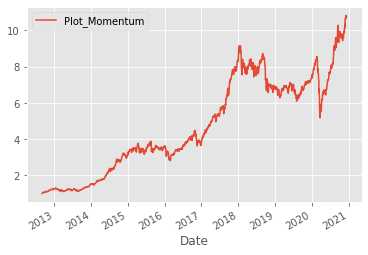

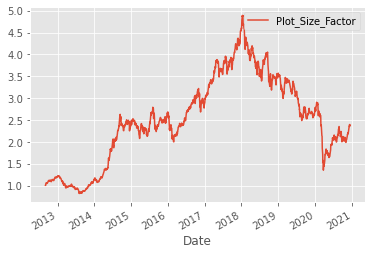

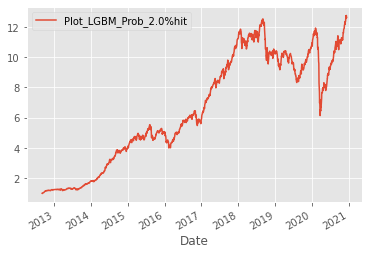

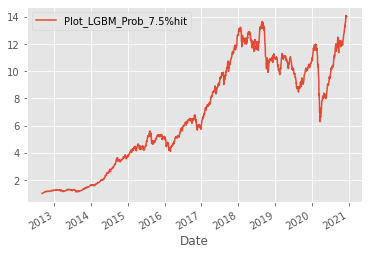

In [35]:
#Select top 40 stocks at each rebalance day with a monthly rebalancing
feature_list=['Momentum','Size_Factor','LGBM_Prob_2.0%hit','LGBM_Prob_7.5%hit']
strategy_data,factor_return_frame=create_strategy_data(concat_df,feature_list,rebalance_period= 22,screen_stock=30)

# Backtesting Nifty 50 Benchmark

Benchmark NIFTY50
0% [############################# ] 100% | ETA: 00:00:00

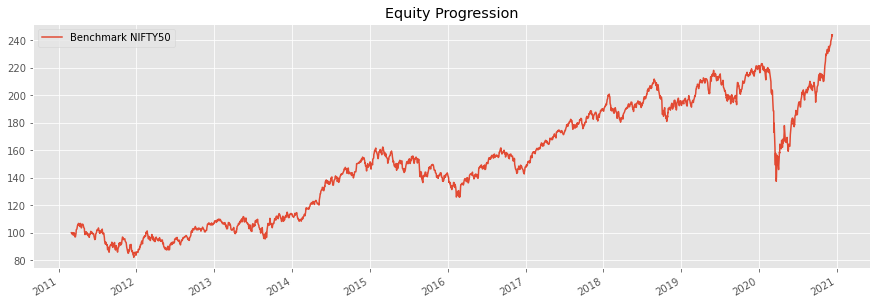

In [36]:
beginning = '2004-06-01'
data_nse50 = bt.get('^NSEI', start=beginning)
data_nse50=data_nse50[data_nse50.index>='3/3/2011']
data_nse50=data_nse50[data_nse50.index<'12/13/2020']
s_nse50 = bt.Strategy('Benchmark NIFTY50', 
                       [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])                    
b_nse50 = bt.Backtest(s_nse50, data_nse50)
result = bt.run(b_nse50)
result.plot()
strategy_data['Benchmark NIFTY50']=result.stats['Benchmark NIFTY50']

# Backtesting Nifty Midcap Benchmark

In [37]:
beginning = '2004-06-01'
data_nsemid100 = bt.get('^CRSMID', start=beginning)
data_nsemid100=data_nsemid100[data_nsemid100.index>='3/3/2011']
data_nsemid100=data_nsemid100[data_nsemid100.index<'12/13/2020']
s_nsemid100 = bt.Strategy('Benchmark NiftyMid', 
                       [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
                    
b_nsemid100 = bt.Backtest(s_nsemid100, data_nsemid100)
result = bt.run(b_nsemid100)
strategy_data['Benchmark NiftyMid']=result.stats['Benchmark NiftyMid']

Benchmark NiftyMid
0% [############################# ] 100% | ETA: 00:00:00

# Writing all strategy metrics like Sharpe Ratio, Return, Risk, Drawdown etc.

In [38]:
strategy_data.to_csv('data\Strategy_LGBM.csv')

In [39]:
# Writing Factor Return to test co-rrelation in ALphaLens
factor_return_frame.to_csv('data/Factor_Return.csv')

# Create a Screener to Invest for a specified amount of INR and specific factor

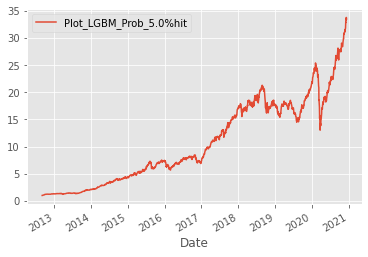

In [40]:
read_nifty=pd.read_csv('NSE_500_Latest.csv')
investment_amount=200000
factor_name_list=['LGBM_Prob_5.0%hit']
for factor_name in factor_name_list:
    z1, concat_df7, screener_out = evaluate_Long_Portfolio(concat_df, factor_name, rebalance_period= 1,screen_stock=10)
    screener_out=screener_out[['Symbol',factor_name]]
    screener_out=screener_out.reset_index()
    screener_out[factor_name]=screener_out.groupby('Date')[factor_name].apply(lambda x:x/sum(x))
    screener=screener_out.merge(concat_df[['Symbol','Date','Adj Close']], how='left', on=(['Date','Symbol']))
    screener=screener.merge(read_nifty[['Symbol','Capitalization','Industry']],how='left',on='Symbol')
    screener['Invest_Amount']=screener[factor_name]*investment_amount
    screener['Shares']=(screener['Invest_Amount']/screener['Adj Close']).round()
    filename="data/Screener_"+factor_name+".csv"
    screener.sort_values('Date',ascending=False).to_csv(filename)